In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
from helper_fn import DataLoader, AccessibilityCalculator, AccessibilityAnalyzer, AccessibilityVisualizer
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
traveltime_path = Path("/Users/keivanjamali/Projects/Pure-Python/P5/11-sustainable/HW2/data/qazvin_cen_to_cen_tt.csv")
jobs_path = Path("/Users/keivanjamali/Projects/Pure-Python/P5/11-sustainable/HW2/data/qazvin_id_jobs_pop.xlsx")
geo_path = Path("/Users/keivanjamali/Projects/Pure-Python/P5/11-sustainable/HW2/data/QazvinNeighborhoods_name_id_Mantagheh.geojson")
data_loader = DataLoader(traveltime_path=traveltime_path, 
                         jobs_path=jobs_path, 
                         geojson_path=geo_path)

## Step 1: Verify Data Loading
Check that all data is loaded correctly.

In [12]:
# Verify data shapes
print(f"Travel Time Data: {data_loader.traveltime.shape}")
print(f"Jobs/Population Data: {data_loader.jobs_pop.shape}")
print(f"Geographic Data: {data_loader.geo_data.shape}")
print(f"\nTravel Time Matrix (pivoted): {data_loader.get_travel_time_matrix().shape}")
print(f"\nUnique Mantagheh (Districts): {data_loader.geo_data['Mantagheh'].nunique()}")
print(data_loader.geo_data['Mantagheh'].unique())

Travel Time Data: (3721, 3)
Jobs/Population Data: (61, 4)
Geographic Data: (61, 5)

Travel Time Matrix (pivoted): (61, 61)

Unique Mantagheh (Districts): 8
['کوثر (هشت)' 'شیشه چی (یک)' 'بلاغی (دو)' 'ملاصدرای شمالی (هفت)'
 'یخچال (پنج)' 'نواب جنوبی (سه)' 'نواب شمالی (چهار)' 'ملاصدرای جنوبی (شش)']


## Step 2: Calculate Accessibility Indicators
- **Gravity-Based**: $A_i = \sum_j O_j \cdot e^{-\beta \cdot t_{ij}}$ with $\beta = 0.1068$
- **Cumulative (30-min)**: $A_i = \sum_j O_j$ where $t_{ij} \leq 30$

In [13]:
# Calculate accessibility using beta = 0.1068 and 30-minute threshold
calculator = AccessibilityCalculator(data_loader, beta=0.1068)
accessibility_results = calculator.calculate_all(threshold=30)

print(f"Accessibility Results Shape: {accessibility_results.shape}")
accessibility_results.head(10)

Accessibility Results Shape: (61, 2)


,jobs_grav,jobs_cumul30
id,,
1,6872.097334,25740
3,7125.093647,42080
4,8802.254202,54810
5,16502.595131,68450
6,4776.255815,8060
7,17879.278516,101430
8,14474.127231,75900
9,23700.443119,105770
10,22141.875124,97990


## Task 1: Generate Accessibility Indicators Table for Each Zone
Create a table with `id`, `jobs_grav`, `jobs_cumul30` for each zone, then aggregate by Mantagheh (district).

In [14]:
# Create analyzer for detailed results
analyzer = AccessibilityAnalyzer(data_loader, accessibility_results)

# Get zone-level results with full information
zone_results = analyzer.get_zone_results_with_info()
print("=== Zone-Level Accessibility Table ===")
zone_results

=== Zone-Level Accessibility Table ===


,name,Mantagheh,jobs,pop,jobs_grav,jobs_cumul30
id,,,,,,
1,کابل البرز,کوثر (هشت),3110,15195,6872.097334,25740
3,اصفهان,شیشه چی (یک),2620,9234,7125.093647,42080
4,راه آهن,بلاغی (دو),2900,5998,8802.254202,54810
5,راه ري,بلاغی (دو),3960,11433,16502.595131,68450
6,وليعصر,بلاغی (دو),2900,5090,4776.255815,8060
...,...,...,...,...,...,...
58,کوثر شمالي,کوثر (هشت),1560,6607,4682.111137,16770
59,کوثر جنوبي,کوثر (هشت),2760,4982,5998.903361,10190
60,پامچال,کوثر (هشت),1910,7510,4197.507285,15760


In [15]:
# Aggregate by Mantagheh (District) - using mean as per the homework requirement
mantagheh_results = analyzer.aggregate_by_mantagheh(method='mean')
print("=== Accessibility by Mantagheh (District) - Mean Values ===")
mantagheh_results

=== Accessibility by Mantagheh (District) - Mean Values ===


,jobs_grav,jobs_cumul30
Mantagheh,,
بلاغی (دو),21269.255124,98994.444444
شیشه چی (یک),17729.017007,90208.888889
ملاصدرای جنوبی (شش),12497.000810,62102.857143
ملاصدرای شمالی (هفت),6670.242725,27025.000000
نواب جنوبی (سه),20195.212508,111978.333333
نواب شمالی (چهار),14607.207452,72605.714286
کوثر (هشت),5352.867275,15837.500000
یخچال (پنج),24138.883138,126391.111111


In [16]:
# Summary Statistics
print("=== Summary Statistics ===")
analyzer.summary_statistics()

=== Summary Statistics ===


,jobs_grav,jobs_cumul30
count,61.000000,61.000000
mean,15770.156145,77770.983607
std,9247.767114,52969.232570
min,2918.430606,2690.000000
25%,7125.093647,25740.000000
50%,15710.659578,74130.000000
75%,23428.968750,120840.000000
max,35191.928061,188210.000000


## Task 2: Create Accessibility Maps
Visualize accessibility indicators using choropleth maps.

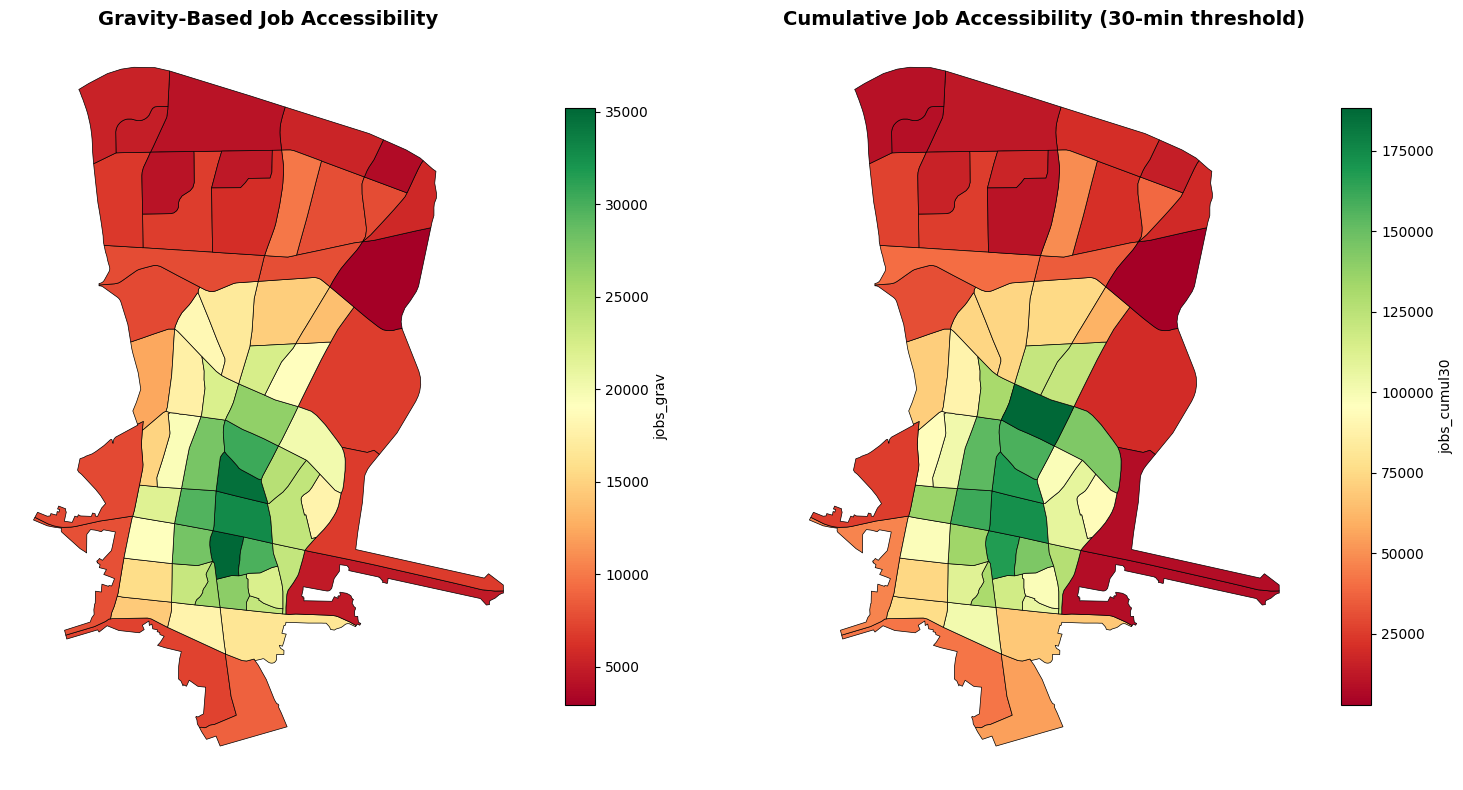

In [17]:
# Create visualizer
visualizer = AccessibilityVisualizer(data_loader, accessibility_results)

# Plot both maps side by side
fig, axes = visualizer.plot_both_maps(figsize=(16, 8), cmap='RdYlGn')
plt.savefig('accessibility_maps.png', dpi=150, bbox_inches='tight')
plt.show()

In [18]:
# Create interactive Folium map for gravity-based accessibility
folium_map_grav = visualizer.create_folium_map(indicator='jobs_grav')
folium_map_grav.save('accessibility_map_gravity.html')
print("Interactive map saved to: accessibility_map_gravity.html")
folium_map_grav

Interactive map saved to: accessibility_map_gravity.html


<string>:76: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [19]:
# Create interactive Folium map for cumulative accessibility (30-min)
folium_map_cumul = visualizer.create_folium_map(indicator='jobs_cumul30')
folium_map_cumul.save('accessibility_map_cumulative30.html')
print("Interactive map saved to: accessibility_map_cumulative30.html")
folium_map_cumul

Interactive map saved to: accessibility_map_cumulative30.html


<string>:76: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



## Task 3: Compare Methods and Justify Your Choice

**Question:** Which method (gravity-based or cumulative opportunities) is more appropriate and why?

In [20]:
# Compare the two methods
comparison_df = zone_results[['name', 'Mantagheh', 'jobs_grav', 'jobs_cumul30']].copy()

# Calculate correlation between methods
correlation = comparison_df['jobs_grav'].corr(comparison_df['jobs_cumul30'])
print(f"Correlation between Gravity and Cumulative methods: {correlation:.4f}")

# Show zones with largest differences (normalized)
comparison_df['grav_normalized'] = comparison_df['jobs_grav'] / comparison_df['jobs_grav'].max()
comparison_df['cumul_normalized'] = comparison_df['jobs_cumul30'] / comparison_df['jobs_cumul30'].max()
comparison_df['difference'] = abs(comparison_df['grav_normalized'] - comparison_df['cumul_normalized'])

print("\n=== Zones with Largest Relative Differences ===")
comparison_df.nlargest(10, 'difference')[['name', 'Mantagheh', 'jobs_grav', 'jobs_cumul30', 'difference']]

Correlation between Gravity and Cumulative methods: 0.9632

=== Zones with Largest Relative Differences ===


,name,Mantagheh,jobs_grav,jobs_cumul30,difference
id,,,,,
42,يخچال,یخچال (پنج),26497.843442,188210,0.247048
37,پادگان,یخچال (پنج),20126.161765,143520,0.190655
40,خيابان عارف,یخچال (پنج),24431.724006,98120,0.172910
36,گلستان,یخچال (پنج),6728.421615,8060,0.148368
11,تنورسازان,بلاغی (دو),26784.822851,116940,0.139780
31,غياث آباد غربي,نواب شمالی (چهار),18300.607137,73610,0.128917
59,کوثر جنوبي,کوثر (هشت),5998.903361,10190,0.116321
9,راه چمان,بلاغی (دو),23700.443119,105770,0.111484
12,بلاغي,بلاغی (دو),35191.928061,167450,0.110302


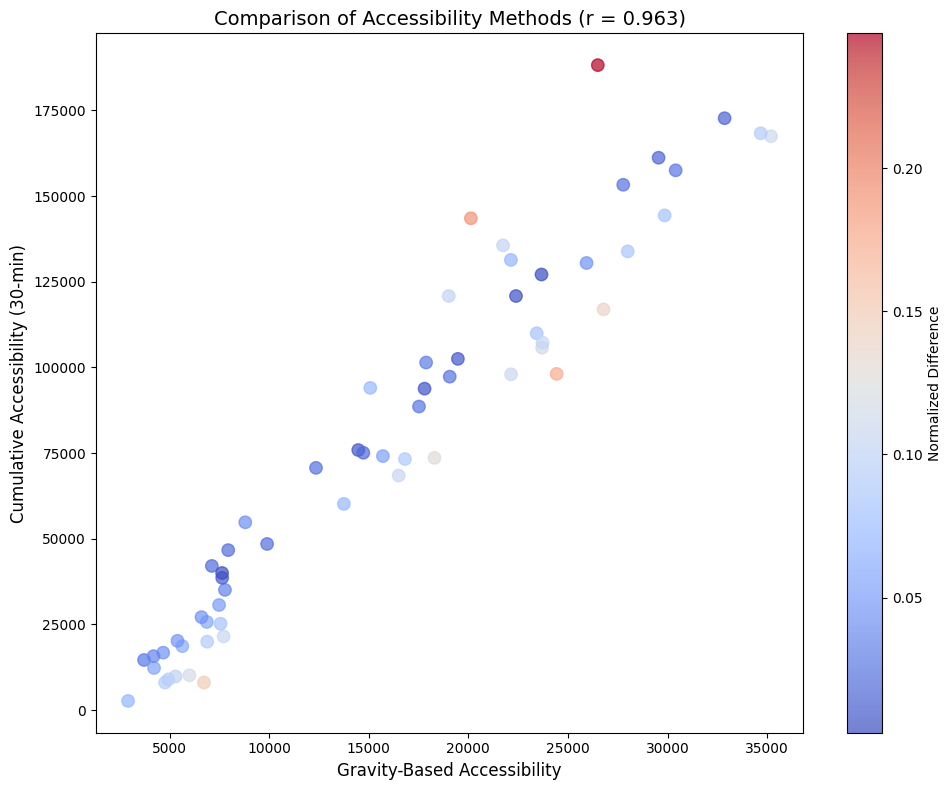

In [21]:
# Scatter plot comparison
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(comparison_df['jobs_grav'], comparison_df['jobs_cumul30'], 
                     c=comparison_df['difference'], cmap='coolwarm', s=80, alpha=0.7)
ax.set_xlabel('Gravity-Based Accessibility', fontsize=12)
ax.set_ylabel('Cumulative Accessibility (30-min)', fontsize=12)
ax.set_title(f'Comparison of Accessibility Methods (r = {correlation:.3f})', fontsize=14)
plt.colorbar(scatter, label='Normalized Difference')
plt.tight_layout()
plt.savefig('method_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Task 4: Analyze Geographic Patterns

**Question:** Why are certain areas more accessible than others?

In [22]:
# Analyze patterns by district
district_analysis = zone_results.groupby('Mantagheh').agg({
    'jobs': 'sum',
    'pop': 'sum',
    'jobs_grav': 'mean',
    'jobs_cumul30': 'mean'
}).round(2)

district_analysis['job_density'] = (district_analysis['jobs'] / district_analysis['pop']).round(4)
district_analysis = district_analysis.sort_values('jobs_grav', ascending=False)

print("=== District Analysis (sorted by gravity accessibility) ===")
district_analysis

=== District Analysis (sorted by gravity accessibility) ===


,jobs,pop,jobs_grav,jobs_cumul30,job_density
Mantagheh,,,,,
یخچال (پنج),69340,48782,24138.88,126391.11,1.4214
بلاغی (دو),51620,41693,21269.26,98994.44,1.2381
نواب جنوبی (سه),40020,31223,20195.21,111978.33,1.2817
شیشه چی (یک),43520,38434,17729.02,90208.89,1.1323
نواب شمالی (چهار),33020,47133,14607.21,72605.71,0.7006
ملاصدرای جنوبی (شش),29360,44687,12497.00,62102.86,0.6570
ملاصدرای شمالی (هفت),14640,35370,6670.24,27025.00,0.4139
کوثر (هشت),18520,69495,5352.87,15837.50,0.2665


In [23]:
# Identify high and low accessibility zones
high_access = zone_results[zone_results['jobs_grav'] >= zone_results['jobs_grav'].quantile(0.75)]
low_access = zone_results[zone_results['jobs_grav'] <= zone_results['jobs_grav'].quantile(0.25)]

print("=== High Accessibility Zones (Top 25%) ===")
print(high_access[['name', 'Mantagheh', 'jobs_grav', 'jobs_cumul30']].to_string())
print(f"\nMean Gravity Score: {high_access['jobs_grav'].mean():.2f}")

print("\n=== Low Accessibility Zones (Bottom 25%) ===")
print(low_access[['name', 'Mantagheh', 'jobs_grav', 'jobs_cumul30']].to_string())
print(f"\nMean Gravity Score: {low_access['jobs_grav'].mean():.2f}")

=== High Accessibility Zones (Top 25%) ===
            name        Mantagheh     jobs_grav  jobs_cumul30
id                                                           
9       راه چمان       بلاغی (دو)  23700.443119        105770
11     تنورسازان       بلاغی (دو)  26784.822851        116940
12         بلاغي       بلاغی (دو)  35191.928061        167450
13      ملک آباد       بلاغی (دو)  29851.630827        144360
14      باغ دبير       بلاغی (دو)  23671.490984        127120
15        خيابان     شیشه چی (یک)  25932.518213        130480
16        دباغان     شیشه چی (یک)  23428.968750        109980
19  سرکوچه ريحان     شیشه چی (یک)  27999.446887        133870
22          خيام      یخچال (پنج)  32860.965861        172720
23           عدل      یخچال (پنج)  34672.568737        168330
24    عبيد زاکان  نواب جنوبی (سه)  29547.446902        161190
26         نادري  نواب جنوبی (سه)  27773.270296        153300
39         بلوار      یخچال (پنج)  23724.878269        107240
40   خيابان عارف      یخچال

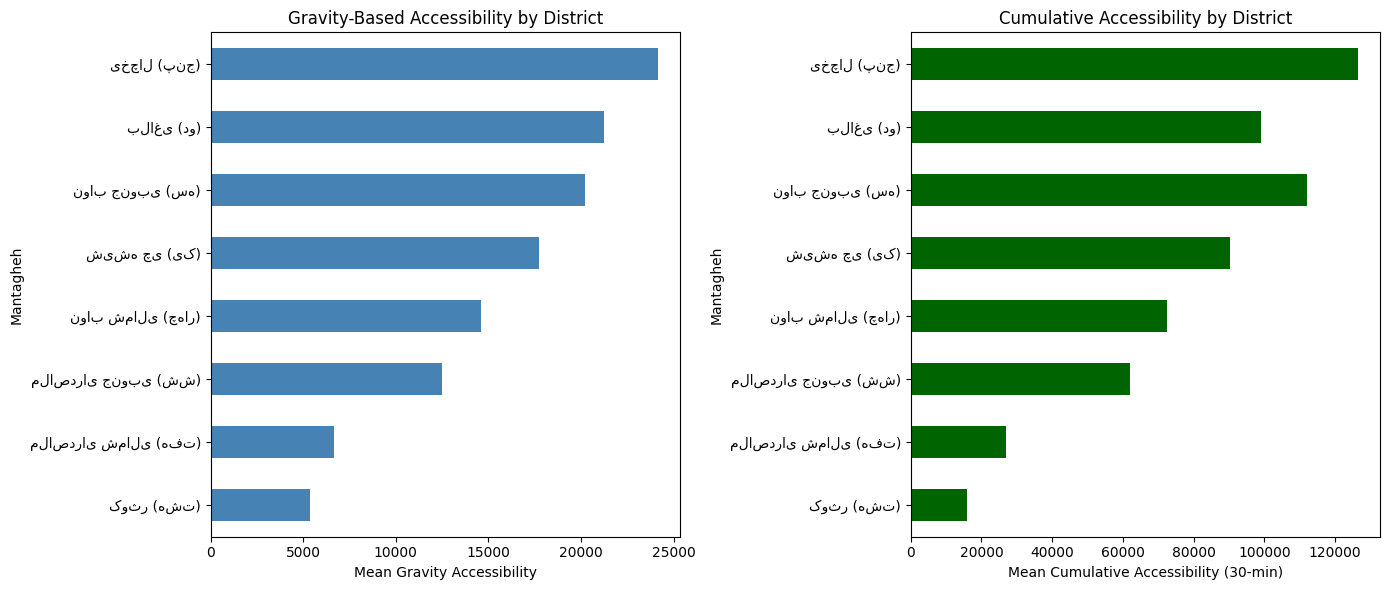

In [24]:
# Visualize accessibility by district (bar chart)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gravity-based by district
mantagheh_sorted = mantagheh_results.sort_values('jobs_grav', ascending=True)
mantagheh_sorted['jobs_grav'].plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Mean Gravity Accessibility')
axes[0].set_title('Gravity-Based Accessibility by District')

# Cumulative by district
mantagheh_sorted['jobs_cumul30'].plot(kind='barh', ax=axes[1], color='darkgreen')
axes[1].set_xlabel('Mean Cumulative Accessibility (30-min)')
axes[1].set_title('Cumulative Accessibility by District')

plt.tight_layout()
plt.savefig('accessibility_by_district.png', dpi=150, bbox_inches='tight')
plt.show()

## Task 5: Recommendations for Improvement

Based on the analysis, provide recommendations to increase accuracy and reliability in accessibility assessment.

In [25]:
# Additional analysis to support recommendations
# Check travel time distribution
tt_long = data_loader.traveltime.copy()
print("=== Travel Time Distribution ===")
print(tt_long['travel_time'].describe())

# Check zones with very high/low travel times
print("\n=== Zones with Extreme Average Travel Times ===")
avg_tt_from = tt_long.groupby('from_id')['travel_time'].mean()
print("\nLongest average travel time (most isolated):")
print(avg_tt_from.nlargest(5))
print("\nShortest average travel time (most central):")
print(avg_tt_from.nsmallest(5))

=== Travel Time Distribution ===
count    3721.000000
mean       43.109110
std        16.648062
min         0.000000
25%        32.000000
50%        43.000000
75%        54.000000
max       101.000000
Name: travel_time, dtype: float64

=== Zones with Extreme Average Travel Times ===

Longest average travel time (most isolated):
from_id
49    74.934426
36    57.344262
52    56.704918
6     56.327869
3     53.327869
Name: travel_time, dtype: float64

Shortest average travel time (most central):
from_id
42    32.557377
44    33.836066
37    34.393443
33    34.803279
23    34.967213
Name: travel_time, dtype: float64


## Export Results

Save all tables and results for the report.

In [26]:
# Export zone-level accessibility table (Task 1 - Part 1)
zone_table = accessibility_results.reset_index()
zone_table.to_csv('task1_zone_accessibility.csv', index=False)
print("✓ Saved: task1_zone_accessibility.csv")

# Export zone-level with full info
zone_results.to_csv('task1_zone_accessibility_full.csv')
print("✓ Saved: task1_zone_accessibility_full.csv")

# Export Mantagheh (district) aggregated results (Task 1 - Part 2)
mantagheh_results.to_csv('task1_mantagheh_accessibility.csv')
print("✓ Saved: task1_mantagheh_accessibility.csv")

# Display final tables
print("\n=== TASK 1: Zone-Level Table (first 15 rows) ===")
print(zone_table.head(15).to_string(index=False))

print("\n=== TASK 1: Mantagheh (District) Table ===")
print(mantagheh_results.to_string())

✓ Saved: task1_zone_accessibility.csv
✓ Saved: task1_zone_accessibility_full.csv
✓ Saved: task1_mantagheh_accessibility.csv

=== TASK 1: Zone-Level Table (first 15 rows) ===
 id    jobs_grav  jobs_cumul30
  1  6872.097334         25740
  3  7125.093647         42080
  4  8802.254202         54810
  5 16502.595131         68450
  6  4776.255815          8060
  7 17879.278516        101430
  8 14474.127231         75900
  9 23700.443119        105770
 10 22141.875124         97990
 11 26784.822851        116940
 12 35191.928061        167450
 13 29851.630827        144360
 14 23671.490984        127120
 15 25932.518213        130480
 16 23428.968750        109980

=== TASK 1: Mantagheh (District) Table ===
                         jobs_grav   jobs_cumul30
Mantagheh                                        
بلاغی (دو)            21269.255124   98994.444444
شیشه چی (یک)          17729.017007   90208.888889
ملاصدرای جنوبی (شش)   12497.000810   62102.857143
ملاصدرای شمالی (هفت)   6670.242725  